# Conditional Text Generation with Transformers

The following code is inspired in the notebook provided by TensorFlow at https://www.tensorflow.org/tutorials/text/transformer

Here we use a simple Transformer model with 2 encoder layers and 2 decoder layers. The goal is to generate a conversation based on the training data.

For further details about Transformers architecture, read the paper *Attention is all you need*: https://arxiv.org/abs/1706.03762

## Prepare and import modules

In [1]:
!pip uninstall -y transformers
!pip install transformers

Found existing installation: transformers 3.0.2
Uninstalling transformers-3.0.2:
  Successfully uninstalled transformers-3.0.2
  Using cached transformers-3.0.2-py3-none-any.whl (769 kB)


In [2]:
import os
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

import tensorflow as tf
from tokenizers import ByteLevelBPETokenizer

/Users/dimasdmm/opt/anaconda3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.2.0-dev20200422). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [3]:
# Set these constants to save the model and tokenizer later
MODEL_NAME = 'simple-transformers'
LANGUAGE = 'english'

# Detect environment
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print('Detected Kaggle environment')
    ARTIFACTS_PATH = 'artifacts/'
    DATA_PATH = '/kaggle/input/<dataset-name>/'
else:
    ARTIFACTS_PATH = '../artifacts/'
    DATA_PATH = '../data/'
    
if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

## Import data

Data source: https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

In [4]:
DATASET_FILE = 'shakespeare.txt'
DATASET_PATH = DATA_PATH + DATASET_FILE

# Read text
with open(DATASET_PATH, 'r', encoding='utf-8') as fp:
    text = fp.read()

# Fix white spaces
text = re.sub(r"[ ]+", ' ', text)
text = re.sub(r"\n[ ]+", "\n", text)
text = re.sub(r"[ ]+\n", "\n", text)

## Tokenize & encode data

In [5]:
# Initialize a BPE tokenizer
tokenizer = ByteLevelBPETokenizer()
special_tokens = [
    '<s>',
    '<pad>',
    '</s>',
    '<unk>',
    '<mask>',
]

# Train tokenize in out dataset
tokenizer.train(files=[DATASET_PATH], vocab_size=52_000, min_frequency=2, special_tokens=special_tokens)

# Save tokenizer to disk, so we can load it later
tokenizer.save_model(ARTIFACTS_PATH, "%s-%s" % (LANGUAGE, MODEL_NAME))

In [6]:
# Obtain IDs of special tokens
START_TOKEN = tokenizer.token_to_id('<s>')
END_TOKEN = tokenizer.token_to_id('</s>')
PAD_TOKEN = tokenizer.token_to_id('<pad>')

In [7]:
def build_dataset(text, tokenizer):
    stokens = tokenizer.encode(text).ids
    
    n_data = len(stokens) - MAX_LEN + 3
    print('To process: %d' % (n_data))
    
    X_data = []
    y_data = []
    
    i = 0
    while i < len(stokens) - MAX_LEN:
        if i % 100000 == 0:
            print('- Processed %d of %d' % (i, n_data))
        
        if len(stokens) - i < 20:
            break
        elif len(stokens) - i < MAX_LEN-3:
            seq_len = len(stokens) - i
        else:
            seq_len = random.randint(20, MAX_LEN-3)
        
        input_ids = stokens[i:(i+seq_len)]
        input_ids = [START_TOKEN] + input_ids + [END_TOKEN] + [PAD_TOKEN]*(MAX_LEN-seq_len-2)
        input_ids = np.asarray(input_ids, dtype='int32')
        X_data.append(input_ids)
        
        target_ids = stokens[(i+1):(i+seq_len+1)]
        target_ids = target_ids + [END_TOKEN] + [PAD_TOKEN]*(MAX_LEN-seq_len-1)
        target_ids = np.asarray(target_ids, dtype='int32')
        y_data.append(target_ids)
        
        i = i + 1

    # To numpy
    X_data = np.asarray(X_data, dtype='int32')
    y_data = np.asarray(y_data, dtype='int32')
    
    return tf.data.Dataset.from_tensor_slices((X_data, y_data)).batch(MAX_LEN+1)

In [8]:
dataset = build_dataset(text, tokenizer)
print('Done!')

To process: 306383
- Processed 0 of 306383
- Processed 100000 of 306383
- Processed 200000 of 306383
- Processed 300000 of 306383
Done!


# Build model

### Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [9]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [10]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

### Define layers

This code comes from TensorFlow documentation. For further details, read https://www.tensorflow.org/tutorials/text/transformer

In [11]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [13]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, rate=0.1):
        super(Encoder, self).__init__()

        maximum_position_encoding = vocab_size
        
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [14]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, rate=0.1):
        super(Decoder, self).__init__()
        
        maximum_position_encoding = vocab_size

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
             look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [15]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               vocab_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               vocab_size, rate)
        self.final_layer = tf.keras.layers.Dense(vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        # Define output
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, vocab_size)

        return final_output, attention_weights

In [16]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, vocab_size=8500)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, vocab_size)

TensorShape([64, 36, 8500])

### Hyperparameters

Due to lack of time and resources, here we define a little Transformer model. Feel free to experiment with other values.

In [17]:
num_layers = 2
d_model = 128
dff = 128
num_heads = 2

vocab_size = tokenizer.get_vocab_size()
dropout_rate = 0.1

### Optimizer

According to the formula of the paper *Attention is all you need*, here we use the Adam optimizer with a custom learning rate scheduler.

In [18]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [19]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

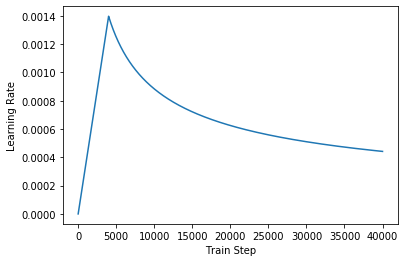

In [20]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [22]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [23]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

### Training

In [24]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [25]:
transformer = Transformer(num_layers,
                          d_model,
                          num_heads,
                          dff,
                          vocab_size=vocab_size,
                          rate=dropout_rate)

In [26]:
checkpoint_path = '%s%s-%s' % (ARTIFACTS_PATH, LANGUAGE, MODEL_NAME)

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [27]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, MAX_LEN), dtype=tf.int32),
    tf.TensorSpec(shape=(None, MAX_LEN), dtype=tf.int32)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [28]:
def format_time(secs):
    if secs < 60:
        return '%ds' % (secs)
    else:
        mins = secs // 60
        secs = secs % 60
        return '%dm%ds' % (mins, secs)

In [29]:
EPOCHS = 2
n_batches = len(list(dataset))

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 50 == 0:
            elapsed = format_time(time.time() - start)
            print('Epoch %d - Batch %d of %d - Loss %.4f - Elapsed %s' % (
                epoch + 1, batch, n_batches, train_loss.result(), elapsed))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print('Epoch {} - Loss {:.4f}'.format(epoch+1, train_loss.result()))

    print('Time taken for epoch: %s\n' % format_time(time.time() - start))

Epoch 1 - Batch 0 of 1193 - Loss 9.5026 - Elapsed 38s
Epoch 1 - Batch 50 of 1193 - Loss 9.4060 - Elapsed 24m23s
Epoch 1 - Batch 100 of 1193 - Loss 9.1626 - Elapsed 49m18s
Epoch 1 - Batch 150 of 1193 - Loss 8.9231 - Elapsed 74m9s
Epoch 1 - Batch 200 of 1193 - Loss 8.6795 - Elapsed 99m11s
Epoch 1 - Batch 250 of 1193 - Loss 8.4077 - Elapsed 123m9s
Epoch 1 - Batch 300 of 1193 - Loss 8.1048 - Elapsed 147m6s
Epoch 1 - Batch 350 of 1193 - Loss 7.7794 - Elapsed 171m38s
Epoch 1 - Batch 400 of 1193 - Loss 7.4442 - Elapsed 195m47s
Epoch 1 - Batch 450 of 1193 - Loss 7.1078 - Elapsed 219m39s
Epoch 1 - Batch 500 of 1193 - Loss 6.7952 - Elapsed 244m40s
Epoch 1 - Batch 550 of 1193 - Loss 6.5087 - Elapsed 269m34s
Epoch 1 - Batch 600 of 1193 - Loss 6.2511 - Elapsed 293m46s
Epoch 1 - Batch 650 of 1193 - Loss 6.0294 - Elapsed 318m2s
Epoch 1 - Batch 700 of 1193 - Loss 5.8341 - Elapsed 341m59s
Epoch 1 - Batch 750 of 1193 - Loss 5.6583 - Elapsed 366m11s
Epoch 1 - Batch 800 of 1193 - Loss 5.5073 - Elapsed 390

## Evaluate

In [43]:
def evaluate(inp_sentence, iters, temperature):
    # inp sentence
    token_ids = tokenizer.encode(inp_sentence).ids
    encoder_input = tf.expand_dims([START_TOKEN] + token_ids[-(MAX_LEN-2):] + [END_TOKEN], 0)

    # as the target
    decoder_input = token_ids[1:][-(MAX_LEN-1):]
    decoder_input = tf.expand_dims(decoder_input, 0)
    
    # generated
    generated_token_ids = list(token_ids)

    for i in range(iters):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, decoder_input)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     decoder_input,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # remove the batch dimension # (batch_size, 1, vocab_size)
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        token_ids.append(predicted_id)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        generated_token_ids.append(predicted_id)
        
        # next inp sentence
        inp_sentence = [START_TOKEN] + token_ids[-(MAX_LEN-2):] + [END_TOKEN]
        encoder_input = tf.expand_dims(inp_sentence, 0)
        
        decoder_input = token_ids[1:][-(MAX_LEN-1):]
        decoder_input = tf.expand_dims(decoder_input, 0)

    return generated_token_ids


def generate(initial_text, iters=5, temperature=1):
    generated_token_ids = evaluate(initial_text, iters, temperature)
    generated_text = tokenizer.decode(generated_token_ids)  

    print('Input: {}'.format(initial_text))
    print('Generated: {}'.format(generated_text))

In [44]:
generate("ROMEO: ", iters=100)

Input: ROMEO: 
Generated: ROMEO:  took perform still sets big,KATHARINA'd me my heart
 l belie to harpets'd upon me
And sure darkness under'd statutes.

 deceive them or orderly and likely body will f roodFor
Masteredon'd conclude else aged asTherefore
The suffer hiswittedWould being royalties and to ouroan as which and than him
The goddess wasYour things curst hag that they admirings that how of they
twere to spirit:
 linger OF glory of follow
ised greatestar


Unfortunately, the generated text seems to be nonsense. It is very likely that if we could train a larger model, we would obtain a better output.